In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.metrics import structural_similarity as compare_ssim
import cv2
import copy
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

Matplotlib is building the font cache; this may take a moment.


# Set up functions for modeling pipeline

In [27]:
# Function for producing differenced image

def img_diff(orig_image, new_image):
    # Convert images to grayscale
    imageA = copy.deepcopy(orig_image)
    imageB = copy.deepcopy(new_image)
    grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")

    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Return the differenced threshold image
    return thresh

In [28]:
# Create function to crop center of image 
def crop_image_center(img, rows, cols):
    
    # Find starting coordinates of top left corner of center crop
    start_row = (img.shape[0] - rows) // 2
    start_col = (img.shape[1] - cols) // 2
    
    new_image = copy.deepcopy(img[start_row:start_row+rows, start_col:start_col+cols, :])
    
    return new_image

In [29]:
# Create function for HOG features
def get_hog(image_set, orient_count, pix_per_cell):
    
    # Initialize list for features and sample images
    feat_list = []
    total_img_count = len(image_set)
  
    # Iterate over images, get HOG features, then stack feature values together
    for z in range(total_img_count):
        orig_im = copy.deepcopy(image_set[z])
        fd, hog_image = hog(orig_im, orientations=orient_count,
                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        feat_list.append(fd[np.newaxis, :])
        
    total_hog = np.vstack(feat_list)
        
    return total_hog

# Create function to calculate classification accuracy
def get_accuracy(predicted, actual):
    correct_count = 0
    for i in range(len(predicted)):
        if predicted[i]==actual[i]:
            correct_count += 1
    return float(correct_count) / len(predicted)

In [30]:
# Function to process a set of pre and post eruption images for a volcano, returns differenced images and labels
def process_imgs(pre_list, post_list, row_crop, col_crop):

    # Load images
    pre1a = []
    for image in pre_list:
        new_img_string = 'ML/' + image
        new_img = plt.imread(new_img_string)
        pre1a.append(new_img)

    post1a = []
    for image in post_list:
        new_img_string = 'ML/' + image
        new_img = plt.imread(new_img_string)
        post1a.append(new_img)   
    
    # Crop images to get exact same dimensions across dataset
    pre1b = []
    for i in range(len(pre1a)):
        new_im = crop_image_center(pre1a[i], row_crop, col_crop)
        pre1b.append(new_im)

    post1b = []
    for i in range(len(post1a)):
        new_im = crop_image_center(post1a[i], row_crop, col_crop)
        post1b.append(new_im)
    
    # Image differencing
    pre2 = []
    for i in range(len(pre1b) - 1):
        new_im = img_diff(pre1b[0], pre1b[i+1])
        pre2.append(new_im)

    post2 = []
    for i in range(len(post1b)):
        new_im = img_diff(pre1b[0], post1b[i])
        post2.append(new_im)

    # Return differenced images in one list and labels in another list
    full_img_list = pre2 + post2
    full_labels = [0]*len(pre2) + [1]*len(post2)

    return full_img_list, full_labels

In [31]:
# Function to arrange train/test split, using processed images and labels from process_img function and a training set percentage
def img_split(img_list_processed, img_labels, pre_img_names, post_img_names, train_pct):
    
    # Calculate count of pre and post eruption images
    post_count = sum(img_labels)
    pre_count = len(img_labels) - post_count
    
    # Split pre and post images and labels into pre-only and post-only lists
    pre3 = copy.deepcopy(img_list_processed[:pre_count])
    post3 = copy.deepcopy(img_list_processed[pre_count:])
    pre_labels = copy.deepcopy(img_labels[:pre_count])
    post_labels = copy.deepcopy(img_labels[pre_count:])

    # Calculate number of training images from pre-only and post-only lists
    train_pre = int(train_pct*pre_count)
    train_post = int(train_pct*post_count)

    # Split train and test sets among pre-only and post-only lists, then combine into full lists of images and labels
    tr_imgs = pre3[:train_pre] + post3[:train_post]
    te_imgs = pre3[train_pre:] + post3[train_post:]
    tr_labels = pre_labels[:train_pre] + post_labels[:train_post]
    te_labels = pre_labels[train_pre:] + post_labels[train_post:]
    tr_imgnames = pre_img_names[1:train_pre+1] + post_img_names[:train_post]
    te_imgnames = pre_img_names[train_pre+1:] + post_img_names[train_post:]

    return tr_imgs, te_imgs, tr_labels, te_labels, tr_imgnames, te_imgnames

In [32]:
# Function to process a set of pre and post eruption images for a volcano, returns a dictionary of original image names as keys and diff-diff images as values
def get_diff_diff(pre_imgs, post_imgs, row_crop, col_crop):

    # Load images
    pre5a = []
    for image in pre_imgs:
        new_img_string = 'ML/' + image
        new_img = plt.imread(new_img_string)
        pre5a.append(new_img)

    post5a = []
    for image in post_imgs:
        new_img_string = 'ML/' + image
        new_img = plt.imread(new_img_string)
        post5a.append(new_img)   
    
    # Crop images to get exact same dimensions across dataset
    pre5b = []
    for i in range(len(pre5a)):
        new_im = crop_image_center(pre5a[i], row_crop, col_crop)
        pre5b.append(new_im)

    post5b = []
    for i in range(len(post5a)):
        new_im = crop_image_center(post5a[i], row_crop, col_crop)
        post5b.append(new_im)
        
    # Add difference of difference images for pre-eruption to output dictionary. Diff-diff for pre images will only have one difference: current minus baseline
    diff_diff_dict1 = {}
    for i in range(len(pre5b) - 1):
        new_im = img_diff(pre5b[0], pre5b[i+1])
        diff_diff_dict1.update({pre_imgs[i+1]: new_im})
        
    # Add difference of difference images for post-eruption to output dictionary. Diff-diff of first post image will only have one difference: current minus baseline
    # Diff-diff of non-first post images will be equal to (i-th post image minus i-th pre image) minus (baseline post image minus baseline pre image)
    for i in range(len(post5b)):
        if i==0:
            new_im = img_diff(pre5b[0], post5b[0])
        else:
            diff1 = img_diff(pre5b[0], post5b[0])
            diff2 = img_diff(pre5b[i], post5b[i])
            new_im = copy.deepcopy(diff2 - diff1)
        diff_diff_dict1.update({post_imgs[i]: new_im})
        
    # Return final output dictionary
    return diff_diff_dict1

# Process Volcano Images for AVH and DVV channels

In [33]:
# Initial image names list for Fournaise
pre_fournaise = ['Fournaise_Piton_de_la_2019-02-11_233020_22343_aVH.png','Fournaise_Piton_de_la_2019-02-25_233020_22343_aVH.png',
                 'Fournaise_Piton_de_la_2019-03-11_233020_22343_aVH.png','Fournaise_Piton_de_la_2019-03-18_233020_22343_aVH.png',
                 'Fournaise_Piton_de_la_2019-04-01_233020_22343_aVH.png']

post_fournaise = ['Fournaise_Piton_de_la_2020-02-10_233020_22343_aVH.png','Fournaise_Piton_de_la_2020-02-17_233020_22343_aVH.png',
                  'Fournaise_Piton_de_la_2020-03-02_233020_22343_aVH.png','Fournaise_Piton_de_la_2020-03-16_233020_22343_aVH.png',
                  'Fournaise_Piton_de_la_2020-04-06_233020_22343_aVH.png']


# Process Fournaise images using process_img function
imgs_fournaise, labels_fournaise = process_imgs(pre_fournaise, post_fournaise, 750, 750)

# Get train and test images and labels for Fournaise using img_split function
tr_imgs_fournaise, te_imgs_fournaise, tr_labels_fournaise, te_labels_fournaise, tr_imgnames_fournaise, te_imgnames_fournaise = img_split(imgs_fournaise, labels_fournaise, pre_fournaise, post_fournaise, 0.7)


In [34]:
# Initial image names list for Fournaise_dvv
pre_fournaise_dvv = ['Fournaise_Piton_de_la_2019-02-11_233020_22343_dVV.png','Fournaise_Piton_de_la_2019-02-25_233020_22343_dVV.png',
                 'Fournaise_Piton_de_la_2019-03-11_233020_22343_dVV.png','Fournaise_Piton_de_la_2019-03-18_233020_22343_dVV.png',
                 'Fournaise_Piton_de_la_2019-04-01_233020_22343_dVV.png']

post_fournaise_dvv = ['Fournaise_Piton_de_la_2020-02-10_233020_22343_dVV.png','Fournaise_Piton_de_la_2020-02-17_233020_22343_dVV.png',
                  'Fournaise_Piton_de_la_2020-03-02_233020_22343_dVV.png','Fournaise_Piton_de_la_2020-03-16_233020_22343_dVV.png',
                  'Fournaise_Piton_de_la_2020-04-06_233020_22343_dVV.png']


# Process Fournaise_dvv images using process_img function
imgs_fournaise_dvv, labels_fournaise_dvv = process_imgs(pre_fournaise_dvv, post_fournaise_dvv, 750, 750)

# Get train and test images and labels for Fournaise_dvv using img_split function
tr_imgs_fournaise_dvv, te_imgs_fournaise_dvv, tr_labels_fournaise_dvv, te_labels_fournaise_dvv, tr_imgnames_fournaise_dvv, te_imgnames_fournaise_dvv = img_split(imgs_fournaise_dvv, labels_fournaise_dvv, pre_fournaise_dvv, post_fournaise_dvv, 0.7)


In [35]:
# Initial image names list for sinabung
pre_sinabung = ['Sinabung_2018-08-08_261080_22365_aVH.png','Sinabung_2018-08-15_261080_22365_aVH.png',
                'Sinabung_2018-08-29_261080_22365_aVH.png','Sinabung_2018-09-12_261080_22365_aVH.png',
                'Sinabung_2018-09-19_261080_22365_aVH.png','Sinabung_2018-10-03_261080_22365_aVH.png',
                'Sinabung_2018-10-24_261080_22365_aVH.png']

post_sinabung = ['Sinabung_2020-08-08_261080_22365_aVH.png','Sinabung_2020-08-15_261080_22365_aVH.png',
                 'Sinabung_2020-08-29_261080_22365_aVH.png','Sinabung_2020-09-12_261080_22365_aVH.png',
                 'Sinabung_2020-09-19_261080_22365_aVH.png','Sinabung_2020-10-03_261080_22365_aVH.png',
                 'Sinabung_2020-10-17_261080_22365_aVH.png']

# Process sinabung images using process_img function
imgs_sinabung, labels_sinabung = process_imgs(pre_sinabung, post_sinabung, 750, 750)

# Get train and test images and labels for sinabung using img_split function
tr_imgs_sinabung, te_imgs_sinabung, tr_labels_sinabung, te_labels_sinabung, tr_imgnames_sinabung, te_imgnames_sinabung = img_split(imgs_sinabung, labels_sinabung, pre_sinabung, post_sinabung, 0.7)


In [36]:
# Initial image names list for sinabung_dvv
pre_sinabung_dvv = ['Sinabung_2018-08-08_261080_22365_dVV.png','Sinabung_2018-08-15_261080_22365_dVV.png',
                'Sinabung_2018-08-29_261080_22365_dVV.png','Sinabung_2018-09-12_261080_22365_dVV.png',
                'Sinabung_2018-09-19_261080_22365_dVV.png','Sinabung_2018-10-03_261080_22365_dVV.png',
                'Sinabung_2018-10-24_261080_22365_dVV.png']

post_sinabung_dvv = ['Sinabung_2020-08-08_261080_22365_dVV.png','Sinabung_2020-08-15_261080_22365_dVV.png',
                 'Sinabung_2020-08-29_261080_22365_dVV.png','Sinabung_2020-09-12_261080_22365_dVV.png',
                 'Sinabung_2020-09-19_261080_22365_dVV.png','Sinabung_2020-10-03_261080_22365_dVV.png',
                 'Sinabung_2020-10-17_261080_22365_dVV.png']

# Process sinabung_dvv images using process_img function
imgs_sinabung_dvv, labels_sinabung_dvv = process_imgs(pre_sinabung_dvv, post_sinabung_dvv, 750, 750)

# Get train and test images and labels for sinabung_dvv using img_split function
tr_imgs_sinabung_dvv, te_imgs_sinabung_dvv, tr_labels_sinabung_dvv, te_labels_sinabung_dvv, tr_imgnames_sinabung_dvv, te_imgnames_sinabung_dvv = img_split(imgs_sinabung_dvv, labels_sinabung_dvv, pre_sinabung_dvv, post_sinabung_dvv, 0.7)


In [37]:
# Initial image names list for kilauea
pre_kilauea = ['Kilauea_2019-12-22_332010_22380_aVH.png','Kilauea_2019-12-29_332010_22380_aVH.png',
               'Kilauea_2020-01-05_332010_22380_aVH.png','Kilauea_2020-01-12_332010_22380_aVH.png',
               'Kilauea_2020-01-19_332010_22380_aVH.png','Kilauea_2020-01-26_332010_22380_aVH.png',
               'Kilauea_2020-02-02_332010_22380_aVH.png','Kilauea_2020-02-09_332010_22380_aVH.png',
               'Kilauea_2020-02-16_332010_22380_aVH.png','Kilauea_2020-02-23_332010_22380_aVH.png',
               'Kilauea_2020-03-01_332010_22380_aVH.png','Kilauea_2020-03-08_332010_22380_aVH.png',
               'Kilauea_2020-03-15_332010_22380_aVH.png']

post_kilauea = ['Kilauea_2020-12-20_332010_22380_aVH.png','Kilauea_2020-12-27_332010_22380_aVH.png',
                'Kilauea_2021-01-03_332010_22380_aVH.png','Kilauea_2021-01-10_332010_22380_aVH.png',
                'Kilauea_2021-01-17_332010_22380_aVH.png','Kilauea_2021-01-24_332010_22380_aVH.png',
                'Kilauea_2021-01-31_332010_22380_aVH.png','Kilauea_2021-02-07_332010_22380_aVH.png',
                'Kilauea_2021-02-14_332010_22380_aVH.png','Kilauea_2021-02-21_332010_22380_aVH.png',
                'Kilauea_2021-02-28_332010_22380_aVH.png','Kilauea_2021-03-07_332010_22380_aVH.png',
                'Kilauea_2021-03-14_332010_22380_aVH.png']

# Process kilauea images using process_img function
imgs_kilauea, labels_kilauea = process_imgs(pre_kilauea, post_kilauea, 750, 750)

# Get train and test images and labels for kilauea using img_split function
tr_imgs_kilauea, te_imgs_kilauea, tr_labels_kilauea, te_labels_kilauea, tr_imgnames_kilauea, te_imgnames_kilauea = img_split(imgs_kilauea, labels_kilauea, pre_kilauea, post_kilauea, 0.7)


In [38]:
# Initial image names list for kilauea_dvv
pre_kilauea_dvv = ['Kilauea_2019-12-22_332010_22380_dVV.png','Kilauea_2019-12-29_332010_22380_dVV.png',
               'Kilauea_2020-01-05_332010_22380_dVV.png','Kilauea_2020-01-12_332010_22380_dVV.png',
               'Kilauea_2020-01-19_332010_22380_dVV.png','Kilauea_2020-01-26_332010_22380_dVV.png',
               'Kilauea_2020-02-02_332010_22380_dVV.png','Kilauea_2020-02-09_332010_22380_dVV.png',
               'Kilauea_2020-02-16_332010_22380_dVV.png','Kilauea_2020-02-23_332010_22380_dVV.png',
               'Kilauea_2020-03-01_332010_22380_dVV.png','Kilauea_2020-03-08_332010_22380_dVV.png',
               'Kilauea_2020-03-15_332010_22380_dVV.png']

post_kilauea_dvv = ['Kilauea_2020-12-20_332010_22380_dVV.png','Kilauea_2020-12-27_332010_22380_dVV.png',
                'Kilauea_2021-01-03_332010_22380_dVV.png','Kilauea_2021-01-10_332010_22380_dVV.png',
                'Kilauea_2021-01-17_332010_22380_dVV.png','Kilauea_2021-01-24_332010_22380_dVV.png',
                'Kilauea_2021-01-31_332010_22380_dVV.png','Kilauea_2021-02-07_332010_22380_dVV.png',
                'Kilauea_2021-02-14_332010_22380_dVV.png','Kilauea_2021-02-21_332010_22380_dVV.png',
                'Kilauea_2021-02-28_332010_22380_dVV.png','Kilauea_2021-03-07_332010_22380_dVV.png',
                'Kilauea_2021-03-14_332010_22380_dVV.png']

# Process kilauea_dvv images using process_img function
imgs_kilauea_dvv, labels_kilauea_dvv = process_imgs(pre_kilauea_dvv, post_kilauea_dvv, 750, 750)

# Get train and test images and labels for kilauea_dvv using img_split function
tr_imgs_kilauea_dvv, te_imgs_kilauea_dvv, tr_labels_kilauea_dvv, te_labels_kilauea_dvv, tr_imgnames_kilauea_dvv, te_imgnames_kilauea_dvv = img_split(imgs_kilauea_dvv, labels_kilauea_dvv, pre_kilauea_dvv, post_kilauea_dvv, 0.7)


In [39]:
# Initial image names list for soufriere
pre_soufriere = ['Soufriere_St_Vincent_2020-01-05_360150_22385_aVH.png','Soufriere_St_Vincent_2020-01-12_360150_22385_aVH.png',
                'Soufriere_St_Vincent_2020-01-26_360150_22385_aVH.png','Soufriere_St_Vincent_2020-02-09_360150_22385_aVH.png',
                'Soufriere_St_Vincent_2020-02-23_360150_22385_aVH.png','Soufriere_St_Vincent_2020-03-01_360150_22385_aVH.png',
                'Soufriere_St_Vincent_2020-03-15_360150_22385_aVH.png','Soufriere_St_Vincent_2020-03-29_360150_22385_aVH.png',
                'Soufriere_St_Vincent_2020-04-05_360150_22385_aVH.png','Soufriere_St_Vincent_2020-04-19_360150_22385_aVH.png']

post_soufriere = ['Soufriere_St_Vincent_2021-01-10_360150_22385_aVH.png','Soufriere_St_Vincent_2021-01-24_360150_22385_aVH.png',
                 'Soufriere_St_Vincent_2021-01-31_360150_22385_aVH.png','Soufriere_St_Vincent_2021-02-07_360150_22385_aVH.png',
                 'Soufriere_St_Vincent_2021-02-21_360150_22385_aVH.png','Soufriere_St_Vincent_2021-02-28_360150_22385_aVH.png',
                 'Soufriere_St_Vincent_2021-03-14_360150_22385_aVH.png','Soufriere_St_Vincent_2021-03-28_360150_22385_aVH.png',
                 'Soufriere_St_Vincent_2021-04-04_360150_22385_aVH.png','Soufriere_St_Vincent_2021-04-18_360150_22385_aVH.png']

# Process soufriere images using process_img function
imgs_soufriere, labels_soufriere = process_imgs(pre_soufriere, post_soufriere, 750, 750)

# Get train and test images and labels for soufriere using img_split function
tr_imgs_soufriere, te_imgs_soufriere, tr_labels_soufriere, te_labels_soufriere, tr_imgnames_soufriere, te_imgnames_soufriere = img_split(imgs_soufriere, labels_soufriere, pre_soufriere, post_soufriere, 0.7)


In [40]:
# Initial image names list for soufriere_dvv
pre_soufriere_dvv = ['Soufriere_St_Vincent_2020-01-05_360150_22385_dVV.png','Soufriere_St_Vincent_2020-01-12_360150_22385_dVV.png',
                'Soufriere_St_Vincent_2020-01-26_360150_22385_dVV.png','Soufriere_St_Vincent_2020-02-09_360150_22385_dVV.png',
                'Soufriere_St_Vincent_2020-02-23_360150_22385_dVV.png','Soufriere_St_Vincent_2020-03-01_360150_22385_dVV.png',
                'Soufriere_St_Vincent_2020-03-15_360150_22385_dVV.png','Soufriere_St_Vincent_2020-03-29_360150_22385_dVV.png',
                'Soufriere_St_Vincent_2020-04-05_360150_22385_dVV.png','Soufriere_St_Vincent_2020-04-19_360150_22385_dVV.png']

post_soufriere_dvv = ['Soufriere_St_Vincent_2021-01-10_360150_22385_dVV.png','Soufriere_St_Vincent_2021-01-24_360150_22385_dVV.png',
                 'Soufriere_St_Vincent_2021-01-31_360150_22385_dVV.png','Soufriere_St_Vincent_2021-02-07_360150_22385_dVV.png',
                 'Soufriere_St_Vincent_2021-02-21_360150_22385_dVV.png','Soufriere_St_Vincent_2021-02-28_360150_22385_dVV.png',
                 'Soufriere_St_Vincent_2021-03-14_360150_22385_dVV.png','Soufriere_St_Vincent_2021-03-28_360150_22385_dVV.png',
                 'Soufriere_St_Vincent_2021-04-04_360150_22385_dVV.png','Soufriere_St_Vincent_2021-04-18_360150_22385_dVV.png']

# Process soufriere_dvv images using process_img function
imgs_soufriere_dvv, labels_soufriere_dvv = process_imgs(pre_soufriere_dvv, post_soufriere_dvv, 750, 750)

# Get train and test images and labels for soufriere_dvv using img_split function
tr_imgs_soufriere_dvv, te_imgs_soufriere_dvv, tr_labels_soufriere_dvv, te_labels_soufriere_dvv, tr_imgnames_soufriere_dvv, te_imgnames_soufriere_dvv = img_split(imgs_soufriere_dvv, labels_soufriere_dvv, pre_soufriere_dvv, post_soufriere_dvv, 0.7)


In [41]:
# Initial image names list for rincon
pre_rincon = ['Rincon_de_la_Vieja_2019-01-31_345020_22346_aVH.png','Rincon_de_la_Vieja_2019-02-14_345020_22346_aVH.png',
              'Rincon_de_la_Vieja_2019-02-28_345020_22346_aVH.png','Rincon_de_la_Vieja_2019-03-07_345020_22346_aVH.png',
              'Rincon_de_la_Vieja_2019-03-21_345020_22346_aVH.png','Rincon_de_la_Vieja_2019-04-04_345020_22346_aVH.png']

post_rincon = ['Rincon_de_la_Vieja_2020-01-30_345020_22346_aVH.png','Rincon_de_la_Vieja_2020-02-06_345020_22346_aVH.png',
               'Rincon_de_la_Vieja_2020-02-20_345020_22346_aVH.png','Rincon_de_la_Vieja_2020-03-05_345020_22346_aVH.png',
               'Rincon_de_la_Vieja_2020-03-12_345020_22346_aVH.png','Rincon_de_la_Vieja_2020-03-26_345020_22346_aVH.png']

# Process rincon images using process_img function
imgs_rincon, labels_rincon = process_imgs(pre_rincon, post_rincon, 750, 750)

# Get train and test images and labels for rincon using img_split function
tr_imgs_rincon, te_imgs_rincon, tr_labels_rincon, te_labels_rincon, tr_imgnames_rincon, te_imgnames_rincon = img_split(imgs_rincon, labels_rincon, pre_rincon, post_rincon, 0.7)

In [42]:
# Initial image names list for rincon_dvv
pre_rincon_dvv = ['Rincon_de_la_Vieja_2019-01-31_345020_22346_dVV.png','Rincon_de_la_Vieja_2019-02-14_345020_22346_dVV.png',
              'Rincon_de_la_Vieja_2019-02-28_345020_22346_dVV.png','Rincon_de_la_Vieja_2019-03-07_345020_22346_dVV.png',
              'Rincon_de_la_Vieja_2019-03-21_345020_22346_dVV.png','Rincon_de_la_Vieja_2019-04-04_345020_22346_dVV.png']

post_rincon_dvv = ['Rincon_de_la_Vieja_2020-01-30_345020_22346_dVV.png','Rincon_de_la_Vieja_2020-02-06_345020_22346_dVV.png',
               'Rincon_de_la_Vieja_2020-02-20_345020_22346_dVV.png','Rincon_de_la_Vieja_2020-03-05_345020_22346_dVV.png',
               'Rincon_de_la_Vieja_2020-03-12_345020_22346_dVV.png','Rincon_de_la_Vieja_2020-03-26_345020_22346_dVV.png']

# Process rincon_dvv images using process_img function
imgs_rincon_dvv, labels_rincon_dvv = process_imgs(pre_rincon_dvv, post_rincon_dvv, 750, 750)

# Get train and test images and labels for rincon_dvv using img_split function
tr_imgs_rincon_dvv, te_imgs_rincon_dvv, tr_labels_rincon_dvv, te_labels_rincon_dvv, tr_imgnames_rincon_dvv, te_imgnames_rincon_dvv = img_split(imgs_rincon_dvv, labels_rincon_dvv, pre_rincon_dvv, post_rincon_dvv, 0.7)


In [43]:
# Initial image names list for turrialba
pre_turrialba = ['Turrialba_2019-07-04_345070_22369_aVH.png','Turrialba_2019-07-11_345070_22369_aVH.png',
                 'Turrialba_2019-07-25_345070_22369_aVH.png','Turrialba_2019-08-08_345070_22369_aVH.png',
                 'Turrialba_2019-08-22_345070_22369_aVH.png']

post_turrialba = ['Turrialba_2020-06-25_345070_22369_aVH.png','Turrialba_2020-07-09_345070_22369_aVH.png',
                  'Turrialba_2020-07-23_345070_22369_aVH.png','Turrialba_2020-07-30_345070_22369_aVH.png',
                  'Turrialba_2020-08-13_345070_22369_aVH.png']

# Process turrialba images using process_img function
imgs_turrialba, labels_turrialba = process_imgs(pre_turrialba, post_turrialba, 750, 750)

# Get train and test images and labels for turrialba using img_split function
tr_imgs_turrialba, te_imgs_turrialba, tr_labels_turrialba, te_labels_turrialba, tr_imgnames_turrialba, te_imgnames_turrialba = img_split(imgs_turrialba, labels_turrialba, pre_turrialba, post_turrialba, 0.7)


In [44]:
# Initial image names list for turrialba_dvv
pre_turrialba_dvv = ['Turrialba_2019-07-04_345070_22369_dVV.png','Turrialba_2019-07-11_345070_22369_dVV.png',
                 'Turrialba_2019-07-25_345070_22369_dVV.png','Turrialba_2019-08-08_345070_22369_dVV.png',
                 'Turrialba_2019-08-22_345070_22369_dVV.png']

post_turrialba_dvv = ['Turrialba_2020-06-25_345070_22369_dVV.png','Turrialba_2020-07-09_345070_22369_dVV.png',
                  'Turrialba_2020-07-23_345070_22369_dVV.png','Turrialba_2020-07-30_345070_22369_dVV.png',
                  'Turrialba_2020-08-13_345070_22369_dVV.png']

# Process turrialba_dvv images using process_img function
imgs_turrialba_dvv, labels_turrialba_dvv = process_imgs(pre_turrialba_dvv, post_turrialba_dvv, 750, 750)

# Get train and test images and labels for turrialba_dvv using img_split function
tr_imgs_turrialba_dvv, te_imgs_turrialba_dvv, tr_labels_turrialba_dvv, te_labels_turrialba_dvv, tr_imgnames_turrialba_dvv, te_imgnames_turrialba_dvv = img_split(imgs_turrialba_dvv, labels_turrialba_dvv, pre_turrialba_dvv, post_turrialba_dvv, 0.7)


# Create Difference of Difference Images to be used in final results

In [45]:
# Create dictionary of diff-diff images across AVH channel images
dd_fournaise_avh = get_diff_diff(pre_fournaise, post_fournaise, 750, 750)
dd_sinabung_avh = get_diff_diff(pre_sinabung, post_sinabung, 750, 750)
dd_kilauea_avh = get_diff_diff(pre_kilauea, post_kilauea, 750, 750)
dd_soufriere_avh = get_diff_diff(pre_soufriere, post_soufriere, 750, 750)
dd_rincon_avh = get_diff_diff(pre_rincon, post_rincon, 750, 750)
dd_turrialba_avh = get_diff_diff(pre_turrialba, post_turrialba, 750, 750)

dd_all_avh = {}
dd_all_avh.update(dd_fournaise_avh)
dd_all_avh.update(dd_sinabung_avh)
dd_all_avh.update(dd_kilauea_avh)
dd_all_avh.update(dd_soufriere_avh)
dd_all_avh.update(dd_rincon_avh)
dd_all_avh.update(dd_turrialba_avh)

In [53]:
# Create dictionary of diff-diff images across DVV channel images
dd_fournaise_dvv = get_diff_diff(pre_fournaise_dvv, post_fournaise_dvv, 750, 750)
dd_sinabung_dvv = get_diff_diff(pre_sinabung_dvv, post_sinabung_dvv, 750, 750)
dd_kilauea_dvv = get_diff_diff(pre_kilauea_dvv, post_kilauea_dvv, 750, 750)
dd_soufriere_dvv = get_diff_diff(pre_soufriere_dvv, post_soufriere_dvv, 750, 750)
dd_rincon_dvv = get_diff_diff(pre_rincon_dvv, post_rincon_dvv, 750, 750)
dd_turrialba_dvv = get_diff_diff(pre_turrialba_dvv, post_turrialba_dvv, 750, 750)

dd_all_dvv = {}
dd_all_dvv.update(dd_fournaise_dvv)
dd_all_dvv.update(dd_sinabung_dvv)
dd_all_dvv.update(dd_kilauea_dvv)
dd_all_dvv.update(dd_soufriere_dvv)
dd_all_dvv.update(dd_rincon_dvv)
dd_all_dvv.update(dd_turrialba_dvv)

# Create model features using HOG for AVH and DVV images

In [54]:
# Process HOG features for AVH images

# Create combined image labels and list of differenced images
img_labels4 = tr_labels_fournaise + tr_labels_sinabung + tr_labels_kilauea + tr_labels_soufriere + tr_labels_rincon + tr_labels_turrialba + te_labels_fournaise + te_labels_sinabung + te_labels_kilauea + te_labels_soufriere + te_labels_rincon + te_labels_turrialba
diff_img_list4 = tr_imgs_fournaise + tr_imgs_sinabung + tr_imgs_kilauea + tr_imgs_soufriere + tr_imgs_rincon + tr_imgs_turrialba + te_imgs_fournaise + te_imgs_sinabung + te_imgs_kilauea + te_imgs_soufriere + te_imgs_rincon + te_imgs_turrialba
total_train_size = len(tr_labels_fournaise + tr_labels_sinabung + tr_labels_kilauea + tr_labels_soufriere + tr_labels_rincon + tr_labels_turrialba)

# Get HOG features using the best parameters previously found: 4 for orientations and 10 for pixels per cell
hog_feat4 = get_hog(diff_img_list4, 4, 10)

# Get top features for HOG using PCA
pca_hog4 = PCA(n_components=10, svd_solver="randomized", random_state=7).fit(hog_feat4)
X_pca_hog4 = pca_hog4.transform(hog_feat4)

# Check dimensions of top features for HOG after PCA
print(X_pca_hog4.shape)
print(" ")

# Convert training set and test set labels and features to numpy arrays
y_train = np.array(img_labels4[:total_train_size])
y_test = np.array(img_labels4[total_train_size:])

X_train = X_pca_hog4[:total_train_size, :]
X_test = X_pca_hog4[total_train_size:, :]

# Normalize feature values using standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(86, 10)
 


In [55]:
# Process HOG features for DVV images

# Create combined image labels and list of differenced images
img_labels_dvv = tr_labels_fournaise_dvv + tr_labels_sinabung_dvv + tr_labels_kilauea_dvv + tr_labels_soufriere_dvv + tr_labels_rincon_dvv + tr_labels_turrialba_dvv + te_labels_fournaise_dvv + te_labels_sinabung_dvv + te_labels_kilauea_dvv + te_labels_soufriere_dvv + te_labels_rincon_dvv + te_labels_turrialba_dvv
diff_img_list_dvv = tr_imgs_fournaise_dvv + tr_imgs_sinabung_dvv + tr_imgs_kilauea_dvv + tr_imgs_soufriere_dvv + tr_imgs_rincon_dvv + tr_imgs_turrialba_dvv + te_imgs_fournaise_dvv + te_imgs_sinabung_dvv + te_imgs_kilauea_dvv + te_imgs_soufriere_dvv + te_imgs_rincon_dvv + te_imgs_turrialba_dvv
total_train_size_dvv = len(tr_labels_fournaise_dvv + tr_labels_sinabung_dvv + tr_labels_kilauea_dvv + tr_labels_soufriere_dvv + tr_labels_rincon_dvv + tr_labels_turrialba_dvv)

# Get HOG features using the best parameters previously found: 4 for orientations and 10 for pixels per cell
hog_feat_dvv = get_hog(diff_img_list_dvv, 4, 10)

# Get top features for HOG using PCA
pca_hog_dvv = PCA(n_components=10, svd_solver="randomized", random_state=7).fit(hog_feat_dvv)
X_pca_hog_dvv = pca_hog_dvv.transform(hog_feat_dvv)

# Check dimensions of top features for HOG after PCA
print(X_pca_hog_dvv.shape)
print(" ")

# Convert training set and test set labels and features to numpy arrays
X_train_dvv = X_pca_hog_dvv[:total_train_size_dvv, :]
X_test_dvv = X_pca_hog_dvv[total_train_size_dvv:, :]

# Normalize feature values using standard scaler
scaler = StandardScaler()
X_train_dvv = scaler.fit_transform(X_train_dvv)
X_test_dvv = scaler.transform(X_test_dvv)


(86, 10)
 


In [56]:
# Combine AVH and DVV features
X_train_comb = np.hstack((X_train, X_train_dvv))
X_test_comb = np.hstack((X_test, X_test_dvv))

# Check dimensions
print(X_train_comb.shape)
print(X_test_comb.shape)

(55, 20)
(31, 20)


# Models Using Random Forest and SVM - SVM is Best

In [57]:
# For combined AVH and DVV image features

# Fit RF model
rf1 = RandomForestClassifier(max_depth=4, min_samples_leaf=1, max_features=6, random_state=7).fit(X_train_comb, y_train)

# Get predictions on training set and calculate classification accuracy
y_predict1 = rf1.predict(X_train_comb)
print("RF model training set accuracy is: ")
print(get_accuracy(y_predict1, y_train))

# Get predictions on test set and calculate classification accuracy
y_predict_rf = rf1.predict(X_test_comb)
print("RF model test set accuracy is: ")
print(get_accuracy(y_predict_rf, y_test))

# Print classification report
print(" ")
print("RF Model Classification Report")
print(classification_report(y_test, y_predict_rf))

RF model training set accuracy is: 
1.0
RF model test set accuracy is: 
0.8064516129032258
 
RF Model Classification Report
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        15
           1       0.73      1.00      0.84        16

    accuracy                           0.81        31
   macro avg       0.86      0.80      0.80        31
weighted avg       0.86      0.81      0.80        31



In [59]:
# For combined AVH and DVV image features

# Fit SVM model
svm1 = SVC(C=15, kernel='rbf').fit(X_train_comb, y_train)

# Get predictions on training set and calculate classification accuracy
y_predict2 = svm1.predict(X_train_comb)
print("SVM model training set accuracy is: ")
print(get_accuracy(y_predict2, y_train))

# Get predictions on test set and calculate classification accuracy
y_predict_svm = svm1.predict(X_test_comb)
print("SVM model test set accuracy is: ")
print(get_accuracy(y_predict_svm, y_test))

# Print classification report
print(" ")
print("SVM Model Classification Report")
print(classification_report(y_test, y_predict_svm))

SVM model training set accuracy is: 
0.9272727272727272
SVM model test set accuracy is: 
0.8709677419354839
 
SVM Model Classification Report
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.83      0.94      0.88        16

    accuracy                           0.87        31
   macro avg       0.88      0.87      0.87        31
weighted avg       0.88      0.87      0.87        31



# Model Output for Pipeline

Test Set: Image File Names - AVH Channel
['Fournaise_Piton_de_la_2019-03-18_233020_22343_aVH.png', 'Fournaise_Piton_de_la_2019-04-01_233020_22343_aVH.png', 'Fournaise_Piton_de_la_2020-03-16_233020_22343_aVH.png', 'Fournaise_Piton_de_la_2020-04-06_233020_22343_aVH.png', 'Sinabung_2018-10-03_261080_22365_aVH.png', 'Sinabung_2018-10-24_261080_22365_aVH.png', 'Sinabung_2020-09-19_261080_22365_aVH.png', 'Sinabung_2020-10-03_261080_22365_aVH.png', 'Sinabung_2020-10-17_261080_22365_aVH.png', 'Kilauea_2020-02-23_332010_22380_aVH.png', 'Kilauea_2020-03-01_332010_22380_aVH.png', 'Kilauea_2020-03-08_332010_22380_aVH.png', 'Kilauea_2020-03-15_332010_22380_aVH.png', 'Kilauea_2021-02-21_332010_22380_aVH.png', 'Kilauea_2021-02-28_332010_22380_aVH.png', 'Kilauea_2021-03-07_332010_22380_aVH.png', 'Kilauea_2021-03-14_332010_22380_aVH.png', 'Soufriere_St_Vincent_2020-03-29_360150_22385_aVH.png', 'Soufriere_St_Vincent_2020-04-05_360150_22385_aVH.png', 'Soufriere_St_Vincent_2020-04-19_360150_22385_aVH.png'

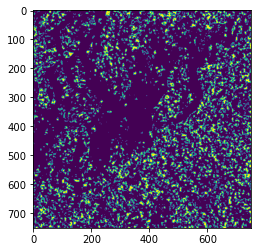

In [71]:
# Final model output components

# Image names of test set
test_img_names_avh = te_imgnames_fournaise + te_imgnames_sinabung + te_imgnames_kilauea + te_imgnames_soufriere + te_imgnames_rincon + te_imgnames_turrialba
test_img_names_dvv = te_imgnames_fournaise_dvv + te_imgnames_sinabung_dvv + te_imgnames_kilauea_dvv + te_imgnames_soufriere_dvv + te_imgnames_rincon_dvv + te_imgnames_turrialba_dvv
print("Test Set: Image File Names - AVH Channel")
print(test_img_names_avh)
print(" ")

# Actual pre/post eruption indicator for test set, 0 is pre, 1 is post
print("Test Set: Actual Indicator")
print(y_test)
print(" ")

# Predicted pre/post eruption indicator for test set, 0 is pre, 1 is post
print("Test Set: Predicted Indicator")
print(y_predict_svm)
print(" ")

# Create list of difference of difference images for test set from AVH channel
diffdiff_imgs_avh = []
for i in test_img_names_avh:
    diffdiff_imgs_avh.append(copy.deepcopy(dd_all_avh[i]))

# Create list of difference of difference images for test set from DVV channel
diffdiff_imgs_dvv = []
for i in test_img_names_dvv:
    diffdiff_imgs_dvv.append(copy.deepcopy(dd_all_dvv[i]))

# One sample diff-diff image printout
print("Test Set: Sample Difference of Difference Image")
plt.imshow(diffdiff_imgs_dvv[29])